In [ ]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os

from image_utils import *
from template_matching import *

dicom_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS25")
segmentation_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS25_Segmentation.nii")

# get 50 random angles to template match
# differentiate lumbar and thoracic
# check which vertebrae label works best
# check why it is not working for what vertebrae

The shape of the image is (100, 672, 672)


Text(0.5, 1.0, 'Applied segmentation mask')

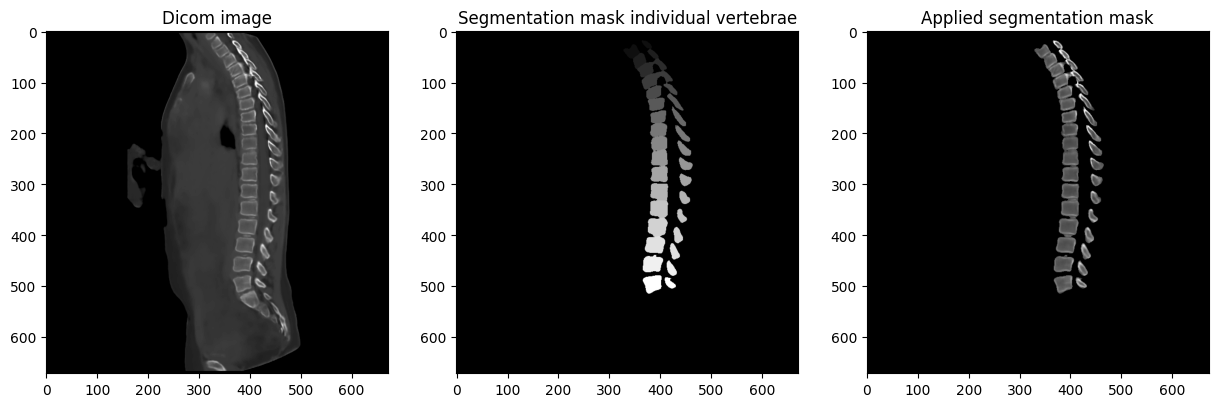

In [2]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask")

In [ ]:
_, _, euler_angles = get_euler_angles(segment_data)
vertebrae_labels = np.unique(segment_data)[1:]
optimized_angles = {}
random_angles = {}

Computed bounding box for 17 vertebra


In [12]:
euler_angles

{1: array([32.38158303, -3.71818677, -5.62393296]),
 2: array([37.7494026 ,  6.49961752, -1.54507085]),
 3: array([-40.69363153,  15.38441397,  -3.71250139]),
 4: array([-34.20841998,   7.22052456,  -2.95452299]),
 5: array([-32.22856923,  -5.03486812,  -1.77380489]),
 6: array([-25.73615033,   0.95347026,   0.94935639]),
 7: array([-24.54589413,   4.29952967,   1.51662225]),
 8: array([-11.61921455,  11.22558893,   1.36395785]),
 9: array([-14.44200794,  35.11253878,  -0.87600119]),
 10: array([ 4.59316817, 27.39455301, -0.37442181]),
 11: array([ 2.95104224, 37.36014394, -1.25325775]),
 12: array([ 4.3737937 , 44.46881392, -0.44883247]),
 13: array([ 7.56143728, 42.39038559,  0.11018645]),
 14: array([10.03270773, 44.25737844,  0.38084797]),
 15: array([10.9465882 , 20.03554219, -1.11191554]),
 16: array([ 3.4209036 , 14.10357615,  1.37749524]),
 17: array([-3.63022724,  5.60364614,  2.30756313])}

In [17]:
bounds = [(-35, 35), (0, 0), (-10, 10)]  # Bounds the sagittal, coronal, and axial angles
n = 20

for label in [12, 13]:
    template = generate_template(segment_dicom_image, segment_data, label, euler_angles)
    if template.shape[0] == 0 or template.shape[1] == 0:
        print(f"Skipping label {label} as the template is empty")
        continue
    else:
        optimized_angles[label] = []
        random_angles[label] = []
    i = 0
    while i < n:
        # Generate random angles
        saggital_angle = np.random.uniform(bounds[0][0], bounds[0][1])
        axial_angle = np.random.uniform(bounds[2][0], bounds[2][1])
        bounds_temp = [(-45 - saggital_angle, 45 - saggital_angle), (0, 0), (-15 - axial_angle, 15 - axial_angle)]

        ROI_3D_image, ref_3D_image, rotated_image, rotated_mask = make_input_3D_ROI(
            segment_dicom_image, segment_data, label, euler_angles,
            saggital_angle=saggital_angle, coronal_angle=0, axial_angle=axial_angle
        )

        try:
            # Try optimizing
            optimal_angles = optimize_rotation(ROI_3D_image, template, bounds_temp)
        
            # Save only if successful
            random_angles[label].append([saggital_angle, 0, axial_angle])
            optimized_angles[label].append(optimal_angles)
            print(f"Best Angles for label {label}: Saggital={optimal_angles[0]} degrees, Coronal={optimal_angles[1]} degrees, Axial={optimal_angles[2]} degrees")
        
            i += 1  # increment only when successful

        except Exception as e:
            print(f"Optimization failed on trial {i+1}: {e}")
            # n is not incremented, so you will retry until you get 20 successful ones

The updated euler angles after initial rotation are:  [-28.65038647  44.46881392  -0.51348376]
Best Angles for label 12: Saggital=-28.458328933707527 degrees, Coronal=0.0 degrees, Axial=-0.523914191448393 degrees
The updated euler angles after initial rotation are:  [-24.36853954  44.46881392   7.48858634]
Best Angles for label 12: Saggital=-24.37924029763112 degrees, Coronal=0.0 degrees, Axial=6.9257252162654 degrees
The updated euler angles after initial rotation are:  [21.16498716 44.46881392 -2.61489386]
Best Angles for label 12: Saggital=21.32357680401131 degrees, Coronal=0.0 degrees, Axial=-2.4318879091600096 degrees
The updated euler angles after initial rotation are:  [32.38956446 44.46881392  6.94878775]
Best Angles for label 12: Saggital=31.874926712021782 degrees, Coronal=0.0 degrees, Axial=5.639924640579451 degrees
The updated euler angles after initial rotation are:  [12.82977168 44.46881392  4.69500796]
Best Angles for label 12: Saggital=12.315956035923048 degrees, Corona

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ================================
# ---- CONFIGURATION ----
# ================================

output_dir = "result_EBS25"
os.makedirs(output_dir, exist_ok=True)

# Define vertebra labels mapping
vertebrae_map = {i: f"T{i}" for i in range(1, 13)}
vertebrae_map.update({i: f"L{i - 12}" for i in range(13, 18)})

# Grouping
thoracic_labels = list(range(1, 13))
lumbar_labels = list(range(13, 18))

# ================================
# ---- COMBINED SCATTER (Mean ± SD) ----
# ================================

plt.figure(figsize=(12, 5))

# Combined Sagittal
plt.subplot(1, 2, 1)
for label in [12, 13]:
    preds = np.array(optimized_angles[label])
    sag_gt = euler_angles[label][0]
    sag_preds = preds[:, 0]

    mean_pred = np.mean(sag_preds)
    std_pred = np.std(sag_preds)

    color = 'blue' if label in thoracic_labels else 'orange'
    plt.errorbar(sag_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
    plt.text(sag_gt, mean_pred, vertebrae_map[label], fontsize=8)

plt.plot([-45, 45], [-45, 45], 'k--')
plt.xlim([-45, 45])
plt.ylim([-45, 45])
plt.title('Combined Sagittal Scatter (Mean ± SD)')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

# Combined Axial
plt.subplot(1, 2, 2)
for label in [12, 13]:
    preds = np.array(optimized_angles[label])
    ax_gt = euler_angles[label][2]
    ax_preds = preds[:, 2]

    mean_pred = np.mean(ax_preds)
    std_pred = np.std(ax_preds)

    color = 'blue' if label in thoracic_labels else 'orange'
    plt.errorbar(ax_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
    plt.text(ax_gt, mean_pred, vertebrae_map[label], fontsize=8)

plt.plot([-15, 15], [-15, 15], 'k--')
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.title('Combined Axial Scatter (Mean ± SD)')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{output_dir}/combined_scatter.png")
plt.close()

# ================================
# ---- COMBINED BLAND-ALTMAN (Mean only) ----
# ================================

# Sagittal
avg_sag, diff_sag, label_sag, color_sag = [], [], [], []
for label in [12, 13]:
    preds = np.array(optimized_angles[label])
    sag_gt = euler_angles[label][0]
    sag_preds = preds[:, 0]
    mean_pred = np.mean(sag_preds)
    
    avg_sag.append((sag_gt + mean_pred) / 2)
    diff_sag.append(mean_pred - sag_gt)
    label_sag.append(vertebrae_map[label])
    color_sag.append('blue' if label in thoracic_labels else 'orange')

avg_sag = np.array(avg_sag)
diff_sag = np.array(diff_sag)

plt.figure(figsize=(6, 5))
for i in range(len(avg_sag)):
    plt.scatter(avg_sag[i], diff_sag[i], color=color_sag[i])
    plt.text(avg_sag[i], diff_sag[i], label_sag[i], fontsize=8)

mean_diff = np.mean(diff_sag)
std_diff = np.std(diff_sag)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean={mean_diff:.2f}')
plt.axhline(loa_upper, color='gray', linestyle='--', label=f'+1.96 SD={loa_upper:.2f}')
plt.axhline(loa_lower, color='gray', linestyle='--', label=f'-1.96 SD={loa_lower:.2f}')

plt.title("Combined Bland-Altman (Sagittal)")
plt.xlabel('Average (GT + Pred) / 2')
plt.ylabel('Difference (Pred - GT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/combined_bland_altman_sagittal.png")
plt.close()

# Axial
avg_ax, diff_ax, label_ax, color_ax = [], [], [], []
for label in [12, 13]:
    preds = np.array(optimized_angles[label])
    ax_gt = euler_angles[label][2]
    ax_preds = preds[:, 2]
    mean_pred = np.mean(ax_preds)
    
    avg_ax.append((ax_gt + mean_pred) / 2)
    diff_ax.append(mean_pred - ax_gt)
    label_ax.append(vertebrae_map[label])
    color_ax.append('blue' if label in thoracic_labels else 'orange')

avg_ax = np.array(avg_ax)
diff_ax = np.array(diff_ax)

plt.figure(figsize=(6, 5))
for i in range(len(avg_ax)):
    plt.scatter(avg_ax[i], diff_ax[i], color=color_ax[i])
    plt.text(avg_ax[i], diff_ax[i], label_ax[i], fontsize=8)

mean_diff = np.mean(diff_ax)
std_diff = np.std(diff_ax)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean={mean_diff:.2f}')
plt.axhline(loa_upper, color='gray', linestyle='--', label=f'+1.96 SD={loa_upper:.2f}')
plt.axhline(loa_lower, color='gray', linestyle='--', label=f'-1.96 SD={loa_lower:.2f}')

plt.title("Combined Bland-Altman (Axial)")
plt.xlabel('Average (GT + Pred) / 2')
plt.ylabel('Difference (Pred - GT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/combined_bland_altman_axial.png")
plt.close()